# Treinamento e predição com imagens rhow
1. Montar dataframe com os valores de profundidade e reflectâncias dos pontos da batimetria
2. Modelagem
3. Cross-validation
4. Filtro NDWI B3 B8 threshold de 0.3
5. Geração da imagem resultado

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tifffile
from pathlib import Path
import pandas as pd
import tqdm
import joblib as jb
from glob import glob
import cv2

## 1. Montar dataframe com os valores de profundidade e reflectâncias dos pontos da batimetria

In [5]:
def get_coord_from_pixel_pos(i, j, start_value_x, start_value_y, scale_x, scale_y):
    """
    i : int - coord x 
    j : int - coord y
    start_value_x : int - start coord x UTM
    start_value_y : int - start coord y UTM
    scale_x : int - pixel/meter scale x
    scale_y : int - pixel/meter scale y
    """
    return (start_value_x+scale_x*i, start_value_y-scale_y*j)

def get_pixel_from_coord(coord_x,coord_y, scale_x, scale_y, start_x, start_y):
    return (int((coord_x-start_x)/scale_x), int((start_y-coord_y)/scale_y))

In [6]:
data_path = "C:/Users/ricar/tccpy/data"

In [7]:
b1 = tifffile.TiffFile(data_path + "/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhow_443.tif")
b2 = tifffile.TiffFile(data_path + "/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhow_492.tif")
b3 = tifffile.TiffFile(data_path + "/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhow_560.tif")
b4 = tifffile.TiffFile(data_path + "/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhow_665.tif")
b5 = tifffile.TiffFile(data_path + "/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhow_704.tif")
b6 = tifffile.TiffFile(data_path + "/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhow_740.tif")
b7 = tifffile.TiffFile(data_path + "/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhow_783.tif")
b8 = tifffile.TiffFile(data_path + "/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhow_833.tif")
path_bat = data_path + "/02.Dados_Processados/02.XYZ/BATIMETRIA_PROCESSADA_BABITONGA_2018_DHN_WGS84_UTM22S.xyz"

In [8]:
b2s = tifffile.TiffFile(data_path + "/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_492.tif")
b3s = tifffile.TiffFile(data_path + "/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_560.tif")
b4s = tifffile.TiffFile(data_path + "/04.Imagens_de_Satelite/02.SR/S2A_MSI_2018_05_20_13_22_41_T22JGR_rhos_665.tif")

In [9]:
aux_dict = dict()
for page in b1.pages:
    for tag in page.tags.values():
        aux_dict[tag.name] = tag.value

scale_x = aux_dict['ModelPixelScaleTag'][0]
scale_y = aux_dict['ModelPixelScaleTag'][1]
start_value_x = aux_dict['ModelTiepointTag'][3]
start_value_y = aux_dict['ModelTiepointTag'][4]

In [10]:
b1 = b1.asarray()
b2 = b2.asarray()
b3 = b3.asarray()
b4 = b4.asarray()
b5 = b5.asarray()
b6 = b6.asarray()
b7 = b7.asarray()
b8 = b8.asarray()

In [11]:
b2s = b2s.asarray()
b3s = b3s.asarray()
b4s = b4s.asarray()

In [12]:
df = pd.read_csv(path_bat, sep=' ', header=None)
df.columns = ['x', 'y', 'z']
df

,x,y,z
0,720507.82,7089857.17,1.96
1,720507.95,7089857.15,1.98
2,720508.07,7089857.12,1.98
3,720508.19,7089857.09,1.97
4,720508.31,7089857.07,1.98
5,720508.42,7089857.04,1.98
6,720508.54,7089857.01,1.96
7,720508.67,7089856.98,1.95
8,720508.79,7089856.94,1.94
9,720508.92,7089856.91,1.94


In [13]:
for i, band in enumerate([b1,b2,b3,b4,b5,b6,b7,b8]):
    column_name = 'b{}'.format(i)
    aux = list()    
    for i, row in enumerate(df.itertuples()):
        x = row[1]
        y = row[2]
        z = row[3]
        pixel = get_pixel_from_coord(x, y, scale_x, scale_y, start_value_x, start_value_y)
        aux.append(band[pixel[1]][pixel[0]])
        
    df[column_name] = aux

In [14]:
df_depth = pd.DataFrame()
df_depth

""


In [15]:
px = list()
py = list()
zlist = list()
    
for i, row in enumerate(df.itertuples()):
    x = row[1]
    y = row[2]
    z = row[3]
    pixel = get_pixel_from_coord(x, y, scale_x, scale_y, start_value_x, start_value_y)
    px.append(pixel[0])
    py.append(pixel[1])
    zlist.append(z)

df_depth['px'] = px
df_depth['py'] = py
df_depth['zmean'] = zlist

In [16]:
df_depth_mean = df_depth.groupby(['px', 'py']).mean()
df_depth_mean.reset_index(inplace=True)
df_depth_mean

,px,py,zmean
0,1324,1076,5.750000
1,1324,1077,5.608810
2,1325,1075,6.010455
3,1325,1076,5.870476
4,1326,1074,6.640000
5,1326,1075,6.396154
6,1327,1074,6.851875
7,1328,1073,7.092381
8,1328,1074,7.087000
9,1329,1072,7.170000


## 2. Modelagem

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

In [77]:
features = df.drop(['z', 'y', 'x'], axis=1)
target = df['z']

In [109]:
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.3)

In [110]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((390070, 8), (390070,), (167174, 8), (167174,))

In [111]:
lgbm = LGBMRegressor(n_estimators=500)

In [112]:
lgbm.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [113]:
p = lgbm.predict(X_val)

In [114]:
r2_score(y_val, p)

0.8894393846428305

In [115]:
space = [(1e-3, 1e-1, 'log-uniform'), # lr
          (1, 10), # max_depth
          (1, 20), # min_child_samples
          (0.05, 1.), # subsample
          (0.05, 1.), # colsample_bytree
          (100,1000)] # n_estimator

In [18]:
from skopt import forest_minimize

def tune_lgbm(args):
    lr = args[0]
    max_depth = args[1]
    min_child_samples = args[2]
    subsample = args[3]
    colsample_bytree = args[4]
    n_estimators = args[5]
    
    mdl = LGBMRegressor(learning_rate=lr, max_depth=max_depth, min_child_samples=min_child_samples, subsample=subsample, colsample_bytree=colsample_bytree, n_estimators=n_estimators)
    mdl.fit(X_train, y_train)
    p = mdl.predict(X_val)
    print(r2_score(y_val, p))
    
    return -r2_score(y_val, p)

In [117]:
res = forest_minimize(tune_lgbm, space, random_state=160000, n_random_starts=20, n_calls=50, verbose=0)

0.5562909471412856
0.7323207710476283
0.6834683920274414
0.35936704941516173
0.438106003785966
0.5240801264996248
0.5132300282684605
0.6342791333330979
0.4028663352056594
0.5761722407346856
0.08258435282130239
0.5390786725163488
0.6399853993241307
0.6011886962835887
0.7042393974578842
0.5104549744835116
0.7628660527926246
0.6310616474362012
0.2590935418307483
0.38911427612665084
0.5752397419736898
0.5457781993020769
0.6404146765270712
0.5779204231511599
0.5564095478825878
0.6014475308038401
0.5745544474369169
0.6660081464269129
0.4049209167136094
0.6391146963604484
0.5681881914883721
0.3072552838454444
0.8387618913711046
0.8321158239888983
0.8723062588959594
0.80216103355312
0.7585159945628897
0.7783272088220403
0.7651240698400208
0.8272453644373163
0.7469305759225014
0.6985216223757149
0.599150467231622
0.4566558724480577
0.8793946111495257
0.8647966266113949
0.9154450114060959
0.8769217243517633
0.9112879585488495
0.9192173529301971


In [118]:
res['x']

[0.09105671542426731, 8, 7, 0.3633869807906197, 0.975267338918986, 895]

In [119]:
hyper = {
    'lr': res['x'][0],
    "max_depth": res['x'][1],
    "min_child_samples": res['x'][2],
    "subsample": res['x'][3],
    'colsample_bytree': res['x'][4],
    'n_estimators': res['x'][5]
}

In [120]:
mdl = LGBMRegressor(learning_rate=hyper['lr'], max_depth=hyper['max_depth'], 
                    min_child_samples=hyper['min_child_samples'], subsample=hyper['subsample'], 
                    colsample_bytree=hyper['colsample_bytree'], n_estimators=hyper['n_estimators'])

In [121]:
mdl.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.975267338918986, importance_type='split',
              learning_rate=0.09105671542426731, max_depth=8,
              min_child_samples=7, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=895, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.3633869807906197, subsample_for_bin=200000,
              subsample_freq=0)

In [122]:
p = mdl.predict(X_val)

In [123]:
r2_score(y_val, p)

0.9192173529301971

In [19]:
import joblib as jb

In [126]:
jb.dump(mdl, 'lgbm_baseline_rhow.pkl.z')

['lgbm_baseline_rhow.pkl.z']

## 3. Cross-validation

In [12]:
from sklearn.model_selection import KFold

def cross_validation():
    global hyper
    k_fold_splits = {}
    kf = KFold(n_splits=10, shuffle=True)
    for i, (lines_train, lines_val) in enumerate(kf.split(features)):
        X_train = features.iloc[lines_train]
        X_val = features.iloc[lines_val]
        y_train = target.iloc[lines_train]
        y_val = target.iloc[lines_val]
        
        mdl = LGBMRegressor(learning_rate=hyper['lr'], max_depth=hyper['max_depth'], 
                    min_child_samples=hyper['min_child_samples'], subsample=hyper['subsample'], 
                    colsample_bytree=hyper['colsample_bytree'], n_estimators=hyper['n_estimators'])
        mdl.fit(X_train, y_train)
        p = mdl.predict(X_val)
        score = r2_score(y_val, p)
        
        k_fold_splits[f'k_fold_{i}'] = score
        
    return k_fold_splits

In [128]:
scores = cross_validation()

In [129]:
scores

{'k_fold_0': 0.9213369974081356,
 'k_fold_1': 0.9214237523548983,
 'k_fold_2': 0.9220827830169023,
 'k_fold_3': 0.9211875911900499,
 'k_fold_4': 0.9216240477222843,
 'k_fold_5': 0.9230431444263273,
 'k_fold_6': 0.9199177216245236,
 'k_fold_7': 0.9210659196030633,
 'k_fold_8': 0.9198077667738165,
 'k_fold_9': 0.9220214444736647}

## 4. Filtro NDWI B3 B8 threshold de 0.3

In [20]:
def ndwi(first_band, second_band):
    if first_band.shape != second_band.shape:
        return None

    output = np.zeros(first_band.shape)

    for i in tqdm.tqdm(range(first_band.shape[0])):
        for j in range(first_band.shape[1]):
            temp1 = first_band[i][j] - second_band[i][j]
            temp2 = first_band[i][j] + second_band[i][j]    
            output[i][j] = temp1/(temp2 if temp2 != 0 else 1)
                
    return output

In [9]:
ndwib3b8 = ndwi(b3,b8)

100%|██████████████████████████████████████████████████████████████████████████████| 5298/5298 [01:22<00:00, 64.23it/s]


In [36]:
wf_th = 0.3

In [37]:
ndwib3b8 = (ndwib3b8[:,:] > wf_th)
ndwib3b8

C:\Users\ricar\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ..., False,  True,  True]])

In [38]:
water_filter = ndwib3b8f.astype(np.uint8)*255

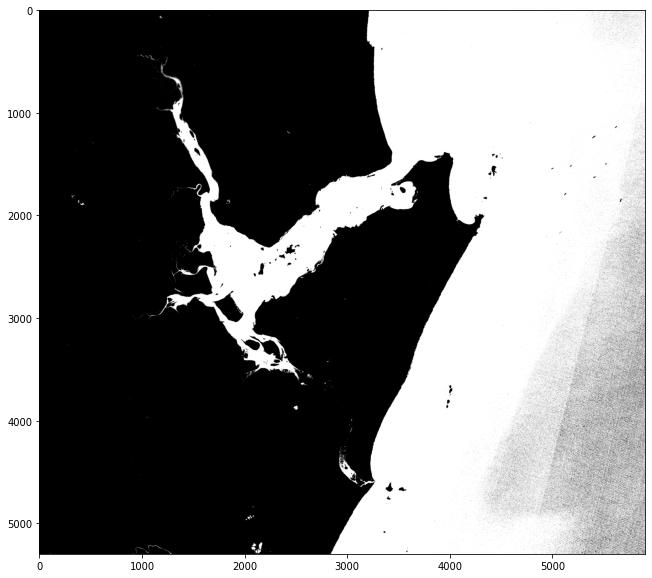

In [39]:
plt.figure(figsize=(12,10))
plt.imshow(water_filter, "gray")

In [21]:
bgr_image = np.dstack((b2s,b3s,b4s))
bgr_image = bgr_image + 0.1
bgr_image = bgr_image.clip(0,1)

In [22]:
bgr_image = (bgr_image*255.99).astype(np.uint8)

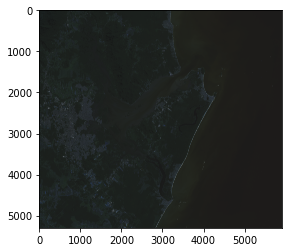

In [184]:
plt.imshow(bgr_image)

In [43]:
cv2.imwrite("rgbresult_rhow.jpg", bgr_image)

True

In [23]:
import joblib as jb
from lightgbm import LGBMRegressor
import colorsys

In [25]:
jb_model_path = "lgbm_baseline_rhow.pkl.z"

In [26]:
lgbm = jb.load(jb_model_path)

In [65]:
aux = list()
for i in tqdm.tqdm(range(bgr_image.shape[0])):
    for j in range(bgr_image.shape[1]):
        if ndwib3b8[i][j]:
            aux.append(np.array([j,i,b1[i][j],b2[i][j],b3[i][j],b4[i][j],b5[i][j],b6[i][j],b7[i][j],b8[i][j]]))
            

100%|██████████████████████████████████████████████████████████████████████████████| 5298/5298 [01:05<00:00, 80.62it/s]


In [66]:
dfaux = pd.DataFrame(aux)

In [67]:
dfaux.columns = ["px","py","b1","b2","b3","b4","b5","b6","b7","b8"]

In [68]:
z = lgbm.predict(dfaux.drop(["px","py"],axis=1))

In [69]:
dfaux["z"] = z

In [70]:
dfaux["z"].describe()

count    1.337566e+07
mean     1.812112e+01
std      5.917733e+00
min     -4.127322e+00
25%      1.562729e+01
50%      1.962926e+01
75%      2.234642e+01
max      4.604612e+01
Name: z, dtype: float64

In [27]:
dfauxpath = "dfaux_rhow.pkl.z"

In [72]:
jb.dump(dfaux,dfauxpath)

['dfaux_rhow.pkl.z']

In [28]:
dfaux = jb.load(dfauxpath)

In [74]:
depth_max = 50
ratio_between_max_and_depth_max = dfaux["z"].max()/depth_max
ratio_between_max_and_depth_max

0.9209223638822351

## 5. Geração da imagem resultado

In [75]:
output = bgr_image.copy()
for i, row in tqdm.tqdm(enumerate(dfaux.itertuples())):
    x = int(row[1])
    y = int(row[2])
    z = row[11]
    output[y][x] = [int(e*255) for e in (colorsys.hls_to_rgb(z/depth_max, 0.5, 1))]

13375663it [01:10, 190907.30it/s]


In [76]:
output = cv2.cvtColor(output,cv2.COLOR_BGR2RGB)

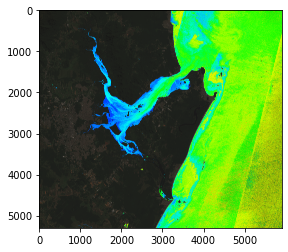

In [77]:
plt.imshow(output)

In [78]:
cv2.imwrite("predictResult_rhow.jpg", output)

True

In [79]:
frame = output.copy()

In [80]:
frame = output.copy()
posx = 0.98
posy = 0.4
height = 0.4
width = 0.1
minDepth = 0
maxDepth = 40
spacing = 5
intervals = int((maxDepth - minDepth)/spacing) + 1

h = int(output.shape[1]*height)
w = int(output.shape[0]*width)
x = int(output.shape[0]*posx)
y = int(output.shape[1]*posy)
cv2.rectangle(frame, (x, y), (x+w,y+h), (255, 255, 255), -1)

cv2.rectangle(frame, (x, y-300), (x+w,y), (255, 255, 255), -1)


font = cv2.FONT_HERSHEY_COMPLEX
fontScale = 4
color = (0, 0, 0)
thickness = 4


pos = (x+50, y-180)
cv2.putText(frame, "Depth", pos, font, fontScale, color, thickness, cv2.LINE_AA)
pos = (x+50, y-40)
fontScale = 3
cv2.putText(frame, "(meters)", pos, font, fontScale, color, thickness, cv2.LINE_AA)

fontScale = 4
for i in range(intervals):
    pos = (x+280, y+150+int(i*h/intervals))
    cv2.putText(frame, str(i*spacing), pos, font, fontScale, color, thickness, cv2.LINE_AA)

iterations = int(maxDepth-minDepth)*100
for i in range(iterations):
    color = [int(e*255) for e in (colorsys.hls_to_rgb(ratio_between_max_and_depth_max*(i/100)/depth_max, 0.5, 1))]
    cv2.rectangle(frame, (x+50, y+int(0.96*h*(i/iterations))+50), (x+int(w/2.5),y+int(0.96*h*(i/iterations))+51), color[::-1], -1)
    

In [81]:
cv2.imwrite("scaleimg_rhow.jpg", frame)

True

In [29]:
dfaux_depth = dfaux.drop(['b1','b2','b3','b4','b5','b6','b7','b8'],axis=1)
dfaux_depth

,px,py,z
0,3214.0,0.0,3.023955
1,3215.0,0.0,3.120459
2,3216.0,0.0,6.916325
3,3217.0,0.0,5.535297
4,3218.0,0.0,19.405055
5,3219.0,0.0,17.941710
6,3220.0,0.0,18.612186
7,3221.0,0.0,18.427180
8,3222.0,0.0,16.736668
9,3223.0,0.0,16.302016


In [91]:
df_merge = pd.merge(df_depth_mean,dfaux_depth,'left',['px','py'])
df_merge

,px,py,zmean,z
0,1324,1076,5.750000,NaN
1,1324,1077,5.608810,NaN
2,1325,1075,6.010455,5.563162
3,1325,1076,5.870476,4.673540
4,1326,1074,6.640000,4.965457
5,1326,1075,6.396154,6.214357
6,1327,1074,6.851875,6.508614
7,1328,1073,7.092381,6.433551
8,1328,1074,7.087000,6.835866
9,1329,1072,7.170000,6.183703


In [31]:
jb_df_depth_comparison_path = "df_depth_comparison"

In [ ]:
jb.dump(df_merge,jb_df_depth_comparison_path)

In [32]:
df_comparison = jb.load(jb_df_depth_comparison_path)
df_comparison.dropna(axis=0,inplace=True)
df_comparison['dif'] = abs(df_comparison['zmean'] - df_comparison['z'])
df_comparison.describe()

,px,py,zmean,z,dif
count,25200.000000,25200.000000,25200.000000,25200.000000,25200.000000
mean,2366.336905,2205.745079,8.100281,8.046621,1.143499
std,620.545262,524.091612,5.178966,4.596480,1.119157
min,1325.000000,1031.000000,1.164255,0.920114,0.000013
25%,1864.000000,1783.000000,3.932342,4.628318,0.378722
50%,2228.000000,2216.000000,6.826416,6.934413,0.835593
75%,2884.000000,2580.000000,11.036933,10.307026,1.547397
max,3632.000000,3414.000000,29.040714,28.542903,12.430641


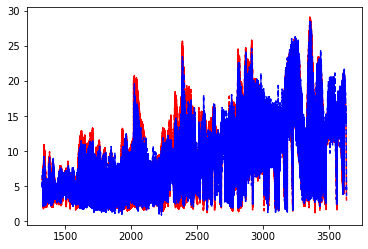

In [33]:
plt.plot(df_comparison['px'], df_comparison['zmean'], 'r--', df_comparison['px'], df_comparison['z'], 'b--')
plt.show()

In [42]:
frame2 = bgr_image.copy()
for i, row in tqdm.tqdm(enumerate(df_comparison.itertuples())):
    x = int(row[1])
    y = int(row[2])
    z = row[5]
    frame2[y][x] = [int(e*255) for e in (colorsys.hls_to_rgb(z/(df_comparison['dif'].max()*1.6), 0.5, 1))]

25200it [00:04, 6268.94it/s]


In [45]:
frame2 = cv2.cvtColor(frame2,cv2.COLOR_BGR2RGB)

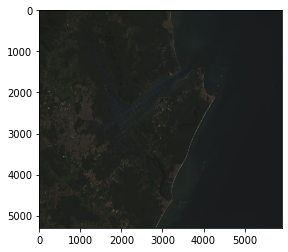

In [46]:
plt.imshow(frame2)

In [47]:
cv2.imwrite("rgb_error_rhow.jpg", frame2)

True

In [48]:
frame3 = bgr_image.copy()
for i, row in tqdm.tqdm(enumerate(df_comparison.itertuples())):
    x = int(row[1])
    y = int(row[2])
    z = row[3]
    frame3[y][x] = [int(e*255) for e in (colorsys.hls_to_rgb(z/(df_comparison['zmean'].max()*1.6), 0.5, 1))]

25200it [00:04, 5555.97it/s]


In [49]:
frame3 = cv2.cvtColor(frame3,cv2.COLOR_BGR2RGB)

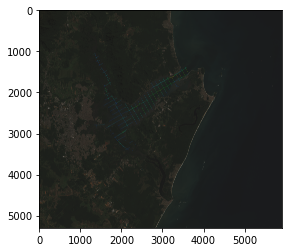

In [50]:
plt.imshow(frame3)

In [51]:
cv2.imwrite("rgb_bat_rhow.jpg", frame3)

True